<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Phyton_kriging: Kriging 1D applied to a row in a asingle image </font>
</div>

- **Fecha**: 2023/06/06
        
- **Objetivos**: Procesamiento de imagen basado en Kriging
- **Descripción** Tutorial for determining how it works

- **Autores**: 
    - Luis Miguel Sánchez Brea
    - Luis Blas Braunschweig Leotte

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import numpy as np

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [63]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 160
rcParams['lines.markersize']=10
# rcParams['image.cmap']='hot'
rcParams['figure.figsize']=(3,3)

%matplotlib widget


# Experimental variogram 

In [64]:

from phyton_kriging import np, plt


from phyton_kriging.variogram_1D import experimental, theoretical, fitting

from phyton_kriging.standard_1D import kriging1D


# Uploading Image

Leemos una imagen cualqueira, se ha elegido una en la que tenemos en cuenta parte del cielo

In [65]:
import cv2

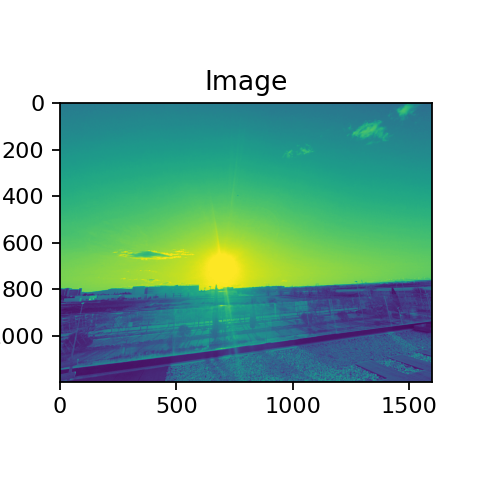

1600


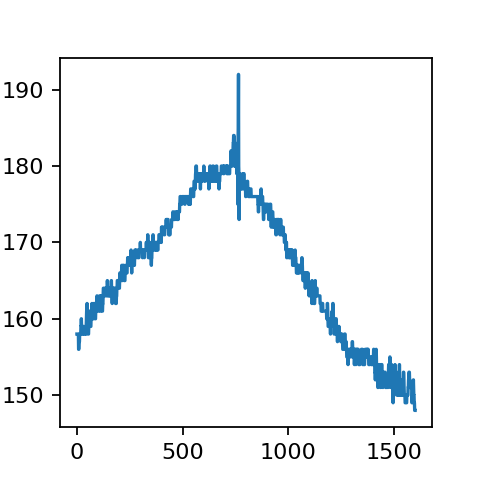

In [66]:
path=r'G0090096_1674924462399.jpg'
image = cv2.imread(path)
color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray)
plt.title('Image')
plt.show()



z=gray[395,:]

plt.figure()
plt.plot(z)

print(len(z))

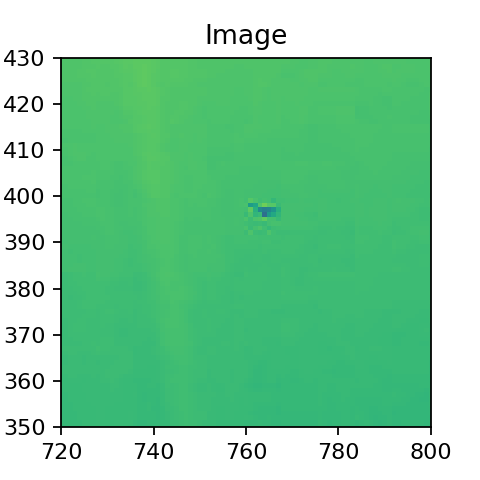

In [67]:
plt.figure()
plt.imshow(gray)
plt.title('Image')
plt.xlim(720,800)
plt.ylim(350,430)
plt.show()

# Variograma en 1D, elección de tipo y parametrización

Para un correcto uso del kriging, necesitamos que nuestro variograma sea el teórico, por lo que realizaremos un variograma experimental de una fila de la imagen, para posteriormente hacerle un fitting y conseguir los parámetros del diagrama teórico correspondiente

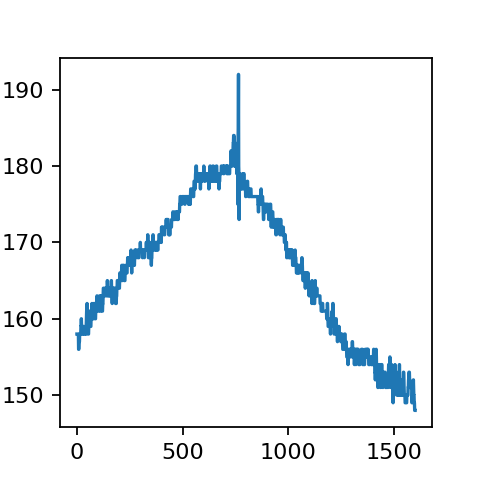

In [68]:
x= np.linspace(0, len(z), len(z))
plt.figure()
plt.plot(x,z)

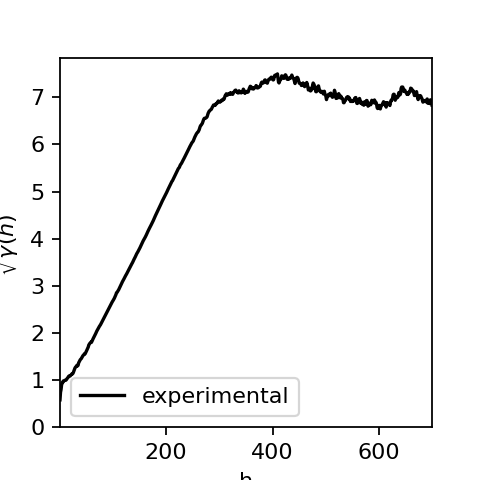

In [69]:
var_exp=experimental(x,z)
i_points = np.arange(0, 700)
 
var_exp.draw()

In [10]:
#TODO
fitting1 = fitting(type='gauss', var_exp=var_exp,                 
                   min_bound=np.array([1, 0, 0]),
                   max_bound=np.array([2, 50, 400]))

In [11]:
fitting1.types()

constant
gauss
exponential
spherical
cubic


['constant', 'gauss', 'exponential', 'spherical', 'cubic']

In [12]:
print(fitting1)

In [13]:

cost, var_final, optimizer = fitting1.execute()


2023-06-15 12:00:05,608 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=3.51
2023-06-15 12:00:07,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.5147507790801304, best pos: [  1.0348  49.9842 224.715 ]


In [52]:
#fitting1.draw_history()

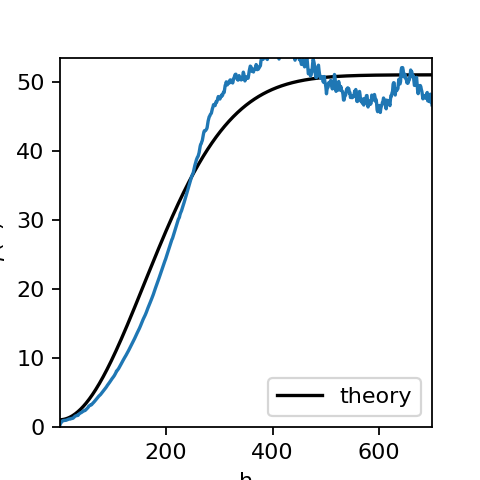

In [15]:
fitting1.draw_fitting('normal')

In [16]:
print(fitting1.param_final)

[  1.0348  49.9842 224.715 ]


constant
gauss
exponential
spherical
cubic


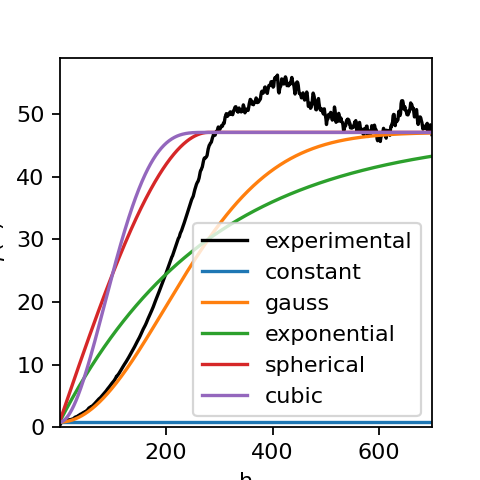

In [17]:
# Voy a ver a mano cual queda mejor de los fittings posibles
from phyton_kriging.variogram_1D import variogram_types
var_theo = theoretical(h=i_points)
var_theo.gauss(sc=0.9, A=(6.8)**2, lc=280)


var_exp.draw('normal')
plt.legend()

for type_var in variogram_types:
    print(type_var) 
    var_theo.type=type_var
    v_new = var_theo.get(i_points)
    plt.plot(i_points, v_new, label=type_var)
    plt.legend()

In [18]:
print(fitting1.param_final)

params_final = fitting1.param_final
params_final[2]=10

[  1.0348  49.9842 224.715 ]


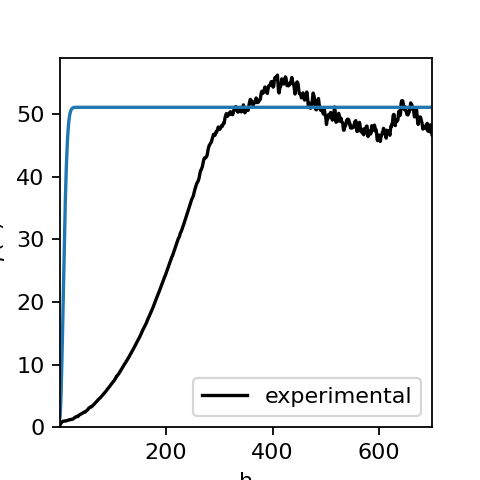

In [19]:
# Voy a intentar hacer el fitting a mano
var_exp.draw('normal')
var_theo = theoretical(h=i_points)
var_theo.gauss(sc=0.9, A=(6.8)**2, lc=280)
var_theo.gauss(*fitting1.param_final)

v_new = var_theo.get(i_points)

plt.plot(i_points, v_new)




# Realizamos el kriging 1D standard

A pesar de no tener un fitting bien conseguido, tenemos tanto una aproximación razonable como, de forma inequivoca, el tipo de diagrama qué es. Por lo que procedemos a intentar hacer el kriging

Definición de parámetros

In [20]:
num_sensors = len(z) #numero de píxeles

sensors = np.zeros((num_sensors, 3), dtype=float)

x = np.linspace(0, num_sensors, num_sensors)

sensors[:, 0] = x
sensors[:, 1] = z
sensors[:, 2] = 0.5 * np.ones_like(sensors[:, 0])


#plt.figure()
#plt.plot(sensors[:, 0], sensors[:, 1], 'b')

In [21]:
print(len(z))

1600


Hacemos el kriging:


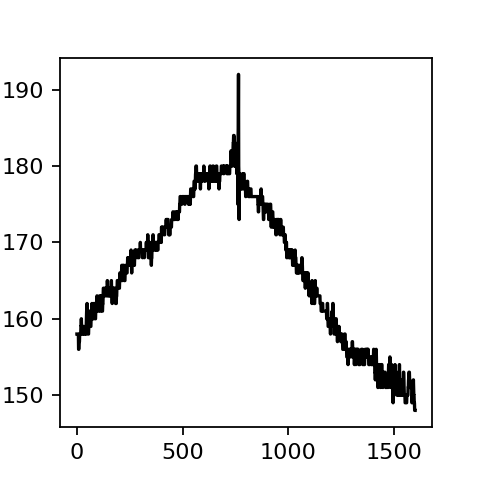

In [22]:
num_sampling=num_sensors
sampling=np.arange(0, num_sampling)
krig1 = kriging1D(sensors=sensors, variogram=var_theo, sampling=sampling)

krig1.standard()
plt.figure()
krig1.draw(kind='data')

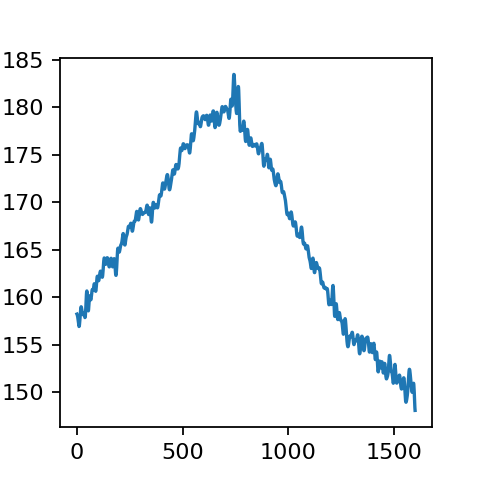

In [23]:
plt.figure()
plt.plot(krig1.estimation)

# Convolution Kriging 1D

Definición de parámetros:

In [48]:
from phyton_kriging.convolution_1D import Convolution_1D
num_sensors = len(z) #numero de píxeles

sensors = np.zeros((num_sensors, 3), dtype=float)

x = np.linspace(0, num_sensors, num_sensors)

sensors[:, 0] = x
sensors[:, 1] = z
sensors[:, 2] = 0.5 * np.ones_like(sensors[:, 0])


#plt.figure()
#plt.plot(sensors[:, 0], sensors[:, 1], 'b')
num_sampling=2*num_sensors
sampling=np.linspace(0, num_sensors, num_sampling)

Aplicamos el algoritmo de convolución:

In [49]:
krig2 = Convolution_1D(sensors=sensors, variogram=var_theo, sampling=sampling)


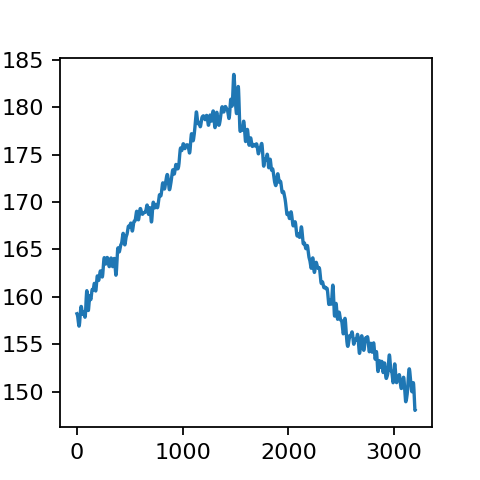

In [51]:
plt.figure()
plt.plot(krig2.estimation)

# ayuda para 2D

In [180]:
num_y,num_x=np.shape(gray)
num_sensors=num_x*num_y

sensors = np.zeros((num_sensors, 4), dtype=float) #Cambiar aquí a 4 si hay ruido

x = np.linspace(0, num_x, num_x)
y = np.linspace(0, num_y, num_y)

X,Y = np.meshgrid(x,y)
x= X.flatten()
y= Y.flatten()
z= gray.flatten()

sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = z
sensors[:, 3] = 0.5*np.zeros_like(x) # ruido perteneciente a la incertidumbre de niveles de grises

sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)
